In [23]:
!pip install -r requirements.txt

In [24]:
# Bibliothèques standard
import os, requests, zipfile

# Data science et manipulation de données
import pandas as pd, numpy as np, geopandas as gpd

# Accès S3
import s3fs


# Fonctions et styles personnalisés importés de visualisation.py
from scripts.visualisation import (
    charte_graphique,
    charte_graphique2,
    charte_graphique3,
    dictionnaire_geo,
    tracer_evolution_taux,
    tracer_evolution_taux_relatif_lisse,
    boxplot_indicateur_par_saison,
    evolution_indicateur_animation,
    animer_evolution_densite,
    evolution_idf_animation,
    get_increase,
    tri_occurrence,
    plot_histogram,
    camembert,
    keywords,
    filter_keyword,
    keywords_occ,
    évolution_indicateur,
    évolution_indicateur,
)

# Pour les tests 
from linearmodels.panel import PanelOLS
from scipy.stats import chi2
from statsmodels.api import add_constant
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "anhlinh"

FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    df_indicateurs_dep = pd.read_csv(file_in_dep)

FILE_PATH_S3_LODA = f"{MY_BUCKET}/diffusion/df_loda.csv"
with fs.open(FILE_PATH_S3_LODA, "rb") as file_in_loda:
    df_loda = pd.read_csv(file_in_loda)

FILE_PATH_S3_NAT = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"
with fs.open(FILE_PATH_S3_NAT, "rb") as file_in_nat:
    df_indicateurs_nat = pd.read_csv(file_in_nat)


Après avoir importé les différents dataframe le but est de les mettre en forme pour pouvoir appliquer nos différentes régressions dessus. Comme nous avons des données sur plusieurs périodes pour plusieurs individus nous allons faire une régression de panel de la forme :

$$
Y_{it} = \alpha + \beta \cdot L_t + \gamma \cdot P_t + \delta \cdot G_{it}+ \mu _i + \epsilon _{it}
$$

où : <br>
$Y_{it}$ : Taux de criminalité des vols sans violence du département i à l'année t<br>
$L_t$ : Mesure de l'intensité législative, comme nous n'avons pas les arrêtés préfectoraux sur légifrance nous sommes contraints d'en faire une variable constante pour tous les départements i, elle est donc seulement indicée par t (les différences entre département viennent donc des variables de contrôles a priori)<br>
$P_t$: Taux de pauvreté annuelle et au niveau nationale, car là nous n'avons accès qu'aux données nationales <br>
$G_{it}$ : Variable de contrôle : pour la table départementale c'est la densité et la population<br>
$\mu _i$ : effet fixe aux départements (pour différences structurelles non observées)<br>
$\epsilon _{it}$ : error term<br>


In [26]:
def mise_en_forme_reg(keyword, indicateur):
    '''
    Prépare un DataFrame structuré pour effectuer une analyse de régression.

    Args:
    keyword (str): Mot-clé utilisé pour filtrer les articles dans le DataFrame `df_loda`.
    indicateur (str): Nom de l'indicateur de criminalité choisi.
    
    Returns: Un DataFrame contenant les données fusionnées et prêtes pour une analyse de régression.
    '''
    # Préparation de LODA
    df_loda_reg = df_loda.drop([ "Unnamed: 0", "ID", "Date", "Nature", "Etat", "Origine", "Date Publication", "Mois"], axis = 1)
    df_loda_filtre = filter_keyword(df_loda_reg,fr"\b{keyword}s?\b")
    df_loda_reg_filtre = df_loda_filtre.groupby("Année").size().reset_index(name="Nombre d'articles")
    
    # Préparation du taux de pauvreté 
    df_indicateurs_nat.head()
    df_indicateurs_nat_reg = df_indicateurs_nat.loc[: ,["Année", "Taux de pauvreté (%)"]]
    df_pauvrete_percent = df_indicateurs_nat_reg.drop_duplicates()

    # Préparation des autres régresseurs et filtrage sur l'indicateur de criminalité choisi
    df_indicateurs_reg = df_indicateurs_dep.drop([ "Unnamed: 0", "Superficie (km2)", "Nombre" , "Département"], axis = 1)
    df_indicateurs_reg = df_indicateurs_reg[df_indicateurs_reg["Indicateur"] == indicateur]

    df_pauvrete_loda_nbr= pd.merge(df_pauvrete_percent, df_loda_reg_filtre, on="Année", how="outer")
    df_reg =pd.merge(df_pauvrete_loda_nbr, df_indicateurs_reg, on = "Année", how = "outer")

    df_reg["Nombre d'articles"] = df_reg["Nombre d'articles"].fillna(0) # On remplace les valeurs manquante par 0
    df_reg = df_reg.drop(["Indicateur"], axis = 1) # On se débarasse de la colonne 'Indicateur' sur laquelle on ne régresse pas
    df_reg = df_reg.set_index(['Nom Département', 'Année']) # On met en index les colonnes qui indices nos variables

    return(df_reg)

In [27]:
mise_en_forme_reg('stupéfiant', "Stupéfiants")

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité
Nom Département,Année,,,,,
Ain,1996,19.3,24.0,499310,11.816307,86.655675
Aisne,1996,19.3,24.0,538017,10.427180,73.080277
Allier,1996,19.3,24.0,349376,7.813931,47.598910
Alpes-de-Haute-Provence,1996,19.3,24.0,137453,24.590224,19.848809
Hautes-Alpes,1996,19.3,24.0,118526,21.598637,21.359885
...,...,...,...,...,...,...
Essonne,2022,19.3,3.0,1319836,26.086574,731.616408
Hauts-de-Seine,2022,19.3,3.0,1641277,30.031494,9325.437500
Seine-Saint-Denis,2022,19.3,3.0,1679240,53.000167,7115.423729


In [28]:
mise_en_forme_reg('vol', 'Vols sans violence')

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité
Nom Département,Année,,,,,
Ain,1996,19.3,0.0,499310,242.494643,86.655675
Aisne,1996,19.3,0.0,538017,319.878368,73.080277
Allier,1996,19.3,0.0,349376,280.099377,47.598910
Alpes-de-Haute-Provence,1996,19.3,0.0,137453,353.066139,19.848809
Hautes-Alpes,1996,19.3,0.0,118526,321.954677,21.359885
...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,1319836,172.347170,731.616408
Hauts-de-Seine,2022,19.3,30.0,1641277,236.248970,9325.437500
Seine-Saint-Denis,2022,19.3,30.0,1679240,255.401253,7115.423729


In [29]:
def regression(df, title, entity_effects=False):
    """
    Effectue une régression sur données de panel, affiche le résumé et trace le graphique.
    Si entity_effects=True, calcule également les effets fixes par département.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        title (str): Ajuster le titre du graphique.
        entity_effects (bool): Inclure ou non les effets fixes des entités (par défaut: False).

    Returns:
        dict: Résultats de la régression, prédictions, résidus et, si applicable, effets fixes.
    """
    # Définir les variables dépendante et explicatives
    y = df['Taux (/10 000)']
    X = df[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
    X = add_constant(X)

    # Modèle de régression
    model = PanelOLS(y, X, entity_effects=entity_effects)
    results = model.fit()

    # Ajouter les prédictions et les résidus dans le DataFrame
    df['Predicted'] = results.predict().fitted_values
    df['Residuals'] = df['Taux (/10 000)'] - df['Predicted']

    # Afficher le résumé
    print(results.summary)

    # Calcul des effets fixes si demandé
    if entity_effects:
        try:
            effects_fixed = results.estimated_effects
            # Extraire l'effet fixe correspondant au Département 
            departments = effects_fixed.index.get_level_values(0)  
            effects_fixed.index = departments  
            print("\nEffets fixes par département:\n", effects_fixed)
        except KeyError as e:
            print(f"Erreur lors de l'accès aux effets fixes: {e}")
        except AttributeError:
            print("Les effets fixes ne sont pas disponibles dans cette configuration.")

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df["Nombre d'articles"], 
        y=df['Taux (/10 000)'], 
        color='blue', 
        alpha=0.6, 
        label='Observations'
    )
    sns.lineplot(
        x=df["Nombre d'articles"], 
        y=df['Predicted'], 
        color='red', 
        label='Prédictions'
    )
    plt.title(title)
    plt.xlabel("Nombre d'articles")
    plt.ylabel("Nombre d'occurences pour 10 000 habitants")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "results": results,
        "df_enriched": df,
        "effects_fixed": effects_fixed,
    }

                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.4125
Estimator:                   PanelOLS   R-squared (Between):             -40.217
No. Observations:                2592   R-squared (Within):               0.4125
Date:                Sun, Dec 29 2024   R-squared (Overall):             -17.346
Time:                        16:05:00   Log-likelihood                   -8220.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      437.34
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2492)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             437.34
                            

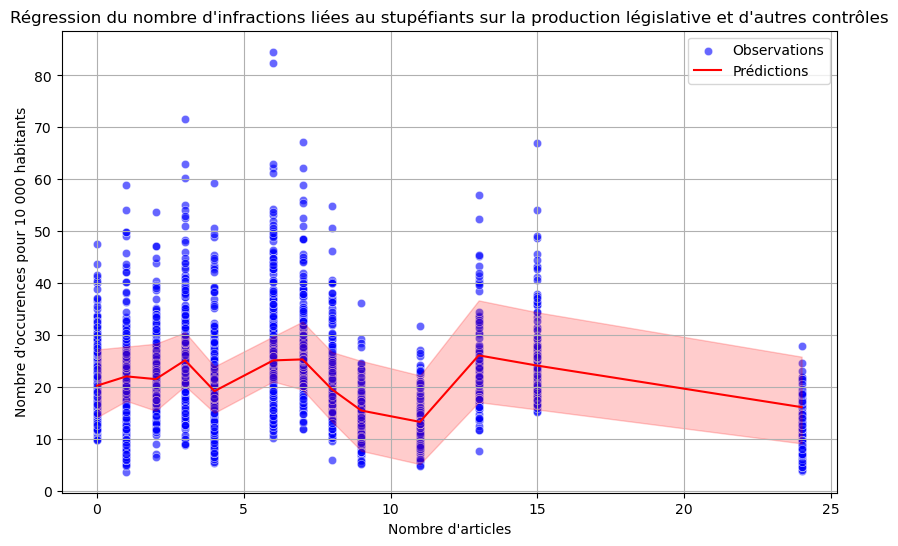

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.4125
 Estimator:                   PanelOLS   R-squared (Between):             -40.217
 No. Observations:                2592   R-squared (Within):               0.4125
 Date:                Sun, Dec 29 2024   R-squared (Overall):             -17.346
 Time:                        16:05:00   Log-likelihood                   -8220.2
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      437.34
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2492)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             437.34
     

In [30]:
regression(mise_en_forme_reg('stupéfiant', "Stupéfiants"), title="Régression du nombre d'infractions liées au stupéfiants sur la production législative et d'autres contrôles", entity_effects=True)

STUPEFIANTS : Le modèle de régression sur données de panel explique environ 31,7% de la variance totale du taux de criminalité, avec une capacité similaire à expliquer les variations temporelles et inter-départements. Le taux de pauvreté apparaît comme le facteur le plus déterminant, avec une relation positive et significative : une augmentation de 1% du taux de pauvreté entraîne une hausse d’environ 4,32 points du taux de criminalité. La densité de population a également un effet positif, bien que marginal. Le modèle est globalement significatif (F = 300,39, p < 0,001), confirmant la pertinence des variables explicatives choisies.

On observe que l'effet de la production législative sur la délinquance liée aux stupéfiants n'est pas linéaire. Par moments, une augmentation du nombre d'articles est associée à une légère hausse des infractions (effet paradoxal), suivie d'une baisse. Cette relation pourrait indiquer que l'impact de la législation est différé ou conditionné par d'autres facteurs (application, contexte socio-économique...).

                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5256
Estimator:                   PanelOLS   R-squared (Between):              0.6174
No. Observations:                2592   R-squared (Within):               0.3357
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5256
Time:                        16:05:26   Log-likelihood                -1.531e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      716.50
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2587)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             716.50
                            

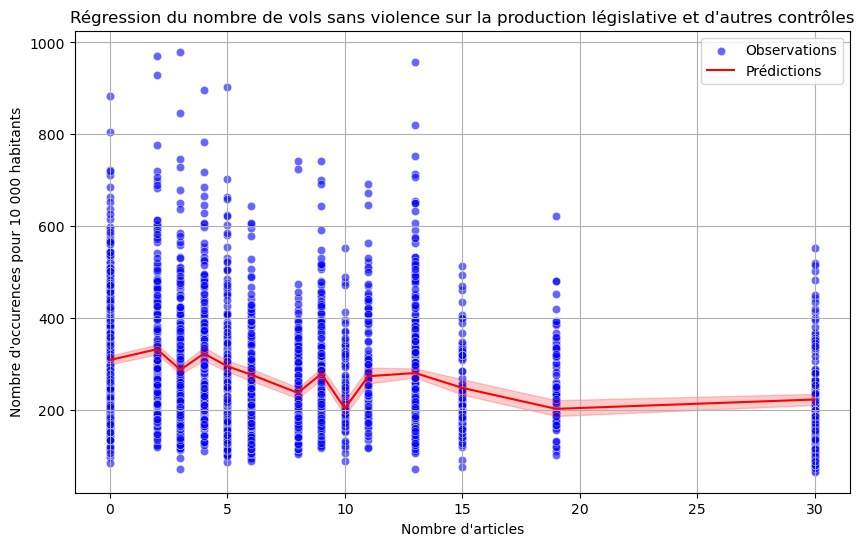

UnboundLocalError: cannot access local variable 'effects_fixed' where it is not associated with a value

In [32]:
regression(mise_en_forme_reg('vol', 'Vols sans violence'), title="Régression du nombre de vols sans violence sur la production législative et d'autres contrôles")

Cette première régression de panel permet d'une part de voir une significance statistique très forte pour tout nos régresseurs, car les p-values associées sont toutes sous les 0.01 conventionnel, mais un effet négatif faible  de ces derniers sur la variable expliquée, à part pour le taux de pauvreté pour lequel l'effet est plus conséquent. Une augmentation de 1% du taux de pauvreté se traduirait dans la variable prédite par une variation d'environ -44, ceteris paribus. (Pour interpréter j'ai l'impression qu'il faudrait se pencher sur les inégalité et non la pauvreté, ce serait une idée reçue d'y voir une corrélation entre pauvreté et délinquance https://www.institutpourlajustice.org/wp-content/uploads/2024/04/Pauvrete-et-delinquance.pdf, https://www.contrepoints.org/2021/07/08/401185-criminalite-non-ce-nest-pas-toujours-la-faute-aux-inegalites-economiques, je ne sais pas trop quoi en penser ni quoi interpréter), le R-Squared est d'environ 0.5 ce qui n'est pas trop mal , mais c'est sûrement dû aux taux de pauvreté. 

Le modèle suivant permet de rendre compte des effets fixe soit des critères fixes, spécifiques aux départements. Nous avons effectué un Wald test, qui assure qu'il est statistiquement préférable de se servir du modèle à effets fixes. Alors ici encore les coefficients sont statistiquement significants pour les même raison, sauf density qui ne l'est plus qu'au 10%. De plus les coefficients ont été réduits de moitié, et le R-squared a un peu augmenté. On contstate que les effets fixes sont conséquents parmi les différentes départements, ce n'est absolument pas étonnant compte tenu de leur diversité.  

<span style="color:red;">**Peut être analyser les effets fixes en despi en focntion des départments ? **</span>

In [19]:
model_FEM = PanelOLS(y, X, entity_effects=True)  # entity_effects=True pour inclure les effets fixes des départements

# Ajuster le modèle
results_FEM = model_FEM.fit()

# Calcul les effets fixes de chaque département
effects_fixed = results_FEM.estimated_effects

print(effects_fixed, results_FEM.summary)


                               estimated_effects
Nom Département         Année                   
Ain                     1996         -101.826746
Aisne                   1996         -129.744210
Allier                  1996         -344.676591
Alpes-de-Haute-Provence 1996         -431.664641
Hautes-Alpes            1996         -481.738690
...                                          ...
Essonne                 2022          561.347087
Hauts-de-Seine          2022         1059.829477
Seine-Saint-Denis       2022         1089.411293
Val-de-Marne            2022          812.603566
Val-d'Oise              2022          614.639002

[2592 rows x 1 columns]                           PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5961
Estimator:                   PanelOLS   R-squared (Between):             -23.703
No. Observations:                2592   R-squared (Within):               0.5961
Date:         

SyntaxError: 'break' outside loop (3398885060.py, line 8)

In [22]:
def Wald_test(FEM_results, Pooled_results)`
    # Statistique du Wald test : différence entre les log-vraisemblances
    wald_stat = 2 * (FEM_results.loglik - Pooled_results.loglik)
    n_entities = df_reg.index.get_level_values(0).nunique() 
    degrees_of_freedom = n_entities- 1 
    p_value = chi2.sf(wald_stat, degrees_of_freedom)

    # 4. Afficher les résultats
    print("Wald Test Statistic:", wald_stat)
    print("Degrees of Freedom:", degrees_of_freedom)
    print("P-value:", p_value)

    # Interprétation
    if p_value < 0.05:
        return("Le modèle FEM est statistiquement significatif. Utilisez FEM.")
    else:
        return("Pas d'évidence pour préférer FEM. Utilisez le modèle pooled OLS.")

Wald_test(results_FEM, results)

Wald Test Statistic: 3322.351157619516
Degrees of Freedom: 95
P-value: 0.0
Le modèle FEM est statistiquement significatif. Utilisez FEM.


Regression qui suit : regression avec décalage temporel de 1 an

/tmp/ipykernel_74730/2427915472.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Articles_lag1'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(1)
/tmp/ipykernel_74730/2427915472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['Taux_lag1'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(1)
/tmp/ipykernel_74730/2427915472.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 


Résultats de la régression avec lag:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5212
Estimator:                   PanelOLS   R-squared (Between):              0.6210
No. Observations:                2493   R-squared (Within):               0.3165
Date:                Sat, Dec 28 2024   R-squared (Overall):              0.5212
Time:                        23:52:50   Log-likelihood                 -1.47e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      677.13
Entities:                          96   P-value                           0.0000
Avg Obs:                       25.969   Distribution:                  F(4,2488)
Min Obs:                       25.000                                           
Max Obs:                       26.000   F-statistic (robust):          

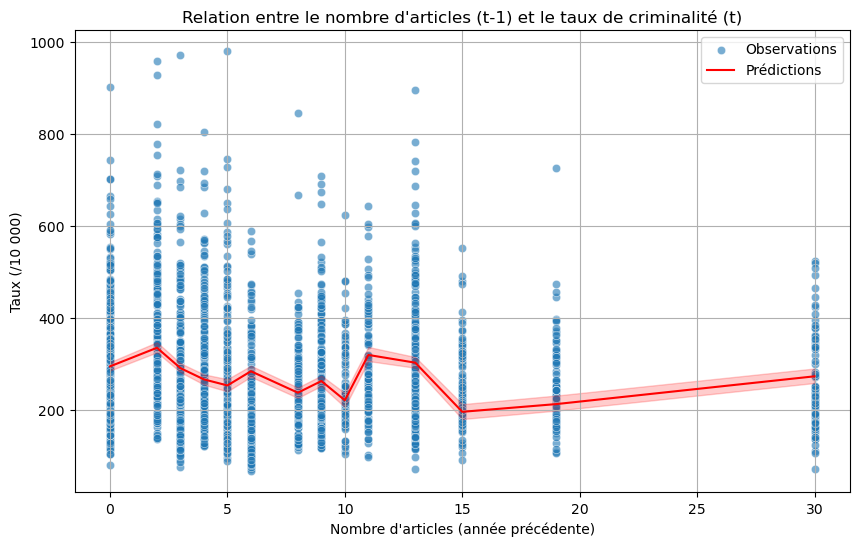

In [ ]:
import pandas as pd
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Création des variables décalées
df_reg['Articles_lag1'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(1)
df_reg['Taux_lag1'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(1)

# Supprimer les lignes avec des NaN créées par le décalage
df_reg["Articles_lag1"] = df_reg["Articles_lag1"].fillna(0)
df_reg["Taux_lag1"] = df_reg["Taux_lag1"].fillna(0)

# Régression
y_lag = df_reg_lag['Taux (/10 000)']
X_lag = df_reg_lag[["Taux de pauvreté (%)", "Articles_lag1", "Population", "Densité"]]
X_lag = sm.add_constant(X_lag)

model_lag = PanelOLS(y_lag, X_lag)
results_lag = model_lag.fit()
print("\nRésultats de la régression avec décalage:")
print(results_lag.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg_lag, x='Articles_lag1', y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg_lag, x='Articles_lag1', y=results_lag.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation entre le nombre d'articles (t-1) et le taux de criminalité (t)")
plt.xlabel("Nombre d'articles (année précédente)")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()

Régression avec décalage temporel de 2 ans :


Résultats de la régression avec décalage:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5097
Estimator:                   PanelOLS   R-squared (Between):              0.6174
No. Observations:                2592   R-squared (Within):               0.2871
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5097
Time:                        00:06:56   Log-likelihood                -1.535e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      672.36
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2587)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):     

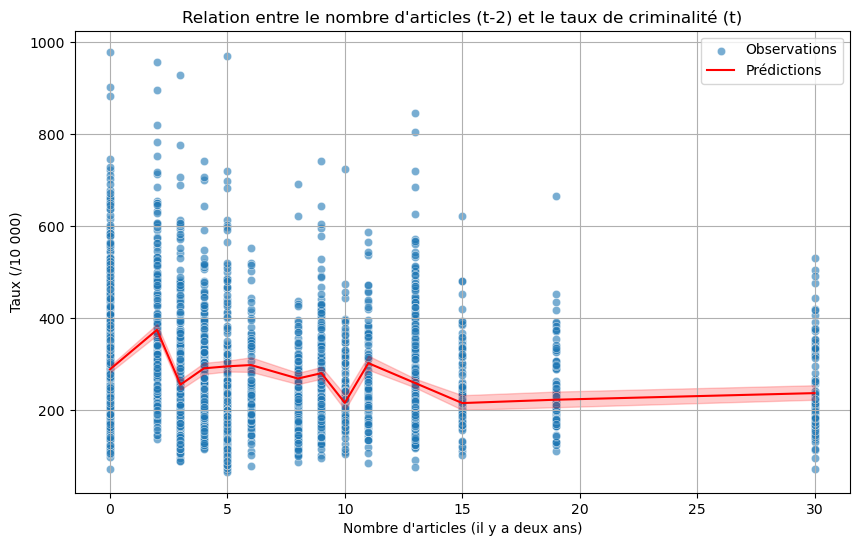

In [73]:
import pandas as pd
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Création des variables décalées de deux ans
df_reg['Articles_lag2'] = df_reg.groupby('Nom Département')["Nombre d'articles"].shift(2)
df_reg['Taux_lag2'] = df_reg.groupby('Nom Département')['Taux (/10 000)'].shift(2)

# Supprimer les lignes avec des NaN créées par le décalage
df_reg["Articles_lag2"] = df_reg["Articles_lag2"].fillna(0)
df_reg["Taux_lag2"] = df_reg["Taux_lag2"].fillna(0)

# Régression
y_lag = df_reg['Taux (/10 000)']
X_lag = df_reg[["Taux de pauvreté (%)", "Articles_lag2", "Population", "Densité"]]
X_lag = sm.add_constant(X_lag)

model_lag = PanelOLS(y_lag, X_lag)
results_lag = model_lag.fit()
print("\nRésultats de la régression avec décalage:")
print(results_lag.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg, x='Articles_lag2', y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg, x='Articles_lag2', y=results_lag.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation entre le nombre d'articles (t-2) et le taux de criminalité (t)")
plt.xlabel("Nombre d'articles (il y a deux ans)")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()


Analyse par type de département :

/opt/conda/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Résultats pour les départements à densité Faible:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.3000
Estimator:                   PanelOLS   R-squared (Between):              0.2282
No. Observations:                1148   R-squared (Within):               0.3630
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.3000
Time:                        00:09:48   Log-likelihood                   -6388.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      122.48
Entities:                          51   P-value                           0.0000
Avg Obs:                       22.510   Distribution:                  F(4,1143)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robus

/opt/conda/lib/python3.12/site-packages/linearmodels/panel/model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)



Résultats pour les départements à densité Forte:
                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.5154
Estimator:                   PanelOLS   R-squared (Between):              0.5727
No. Observations:                1156   R-squared (Within):               0.4700
Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5154
Time:                        00:09:48   Log-likelihood                   -6934.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      306.02
Entities:                          50   P-value                           0.0000
Avg Obs:                       23.120   Distribution:                  F(4,1151)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust

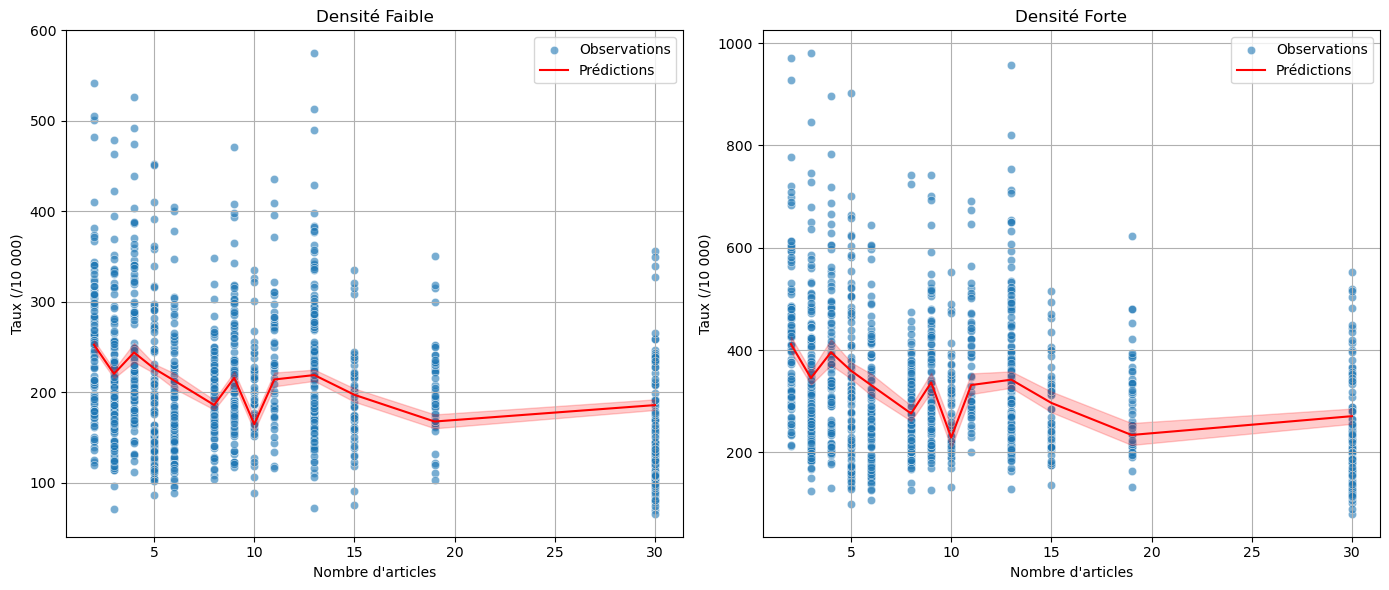

In [74]:
# Création des catégories de densité (2 groupes : Faible et Forte)
df_reg['Densité_cat'] = pd.qcut(df_reg['Densité'], q=2, labels=['Faible', 'Forte'])

# Régressions séparées pour chaque catégorie
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
categories = ['Faible', 'Forte']

for i, cat in enumerate(categories):
    # Filtrer les données
    df_temp = df_reg[df_reg['Densité_cat'] == cat]
    
    # Régression
    y_cat = df_temp['Taux (/10 000)']
    X_cat = df_temp[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
    X_cat = sm.add_constant(X_cat)
    
    model_cat = PanelOLS(y_cat, X_cat)
    results_cat = model_cat.fit()
    print(f"\nRésultats pour les départements à densité {cat}:")
    print(results_cat.summary)
    
    # Visualisation
    sns.scatterplot(data=df_temp, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=axes[i], label='Observations')
    sns.lineplot(data=df_temp, x="Nombre d'articles", y=results_cat.predict().fitted_values, color='red', ax=axes[i], label='Prédictions')
    axes[i].set_title(f"Densité {cat}")
    axes[i].set_xlabel("Nombre d'articles")
    axes[i].set_ylabel("Taux (/10 000)")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


Régression par sous-périodes :

In [ ]:
'''

# Division en sous-périodes
df_reg_early = df_reg[df_reg['Année'] < 2010]
df_reg_late = df_reg[df_reg['Année'] >= 2010]

# Régression période précoce
y_early = df_reg_early['Taux (/10 000)']
X_early = df_reg_early[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_early = sm.add_constant(X_early)

model_early = PanelOLS(y_early, X_early)
results_early = model_early.fit()
print("\nRésultats pour la période avant 2010:")
print(results_early.summary)

# Régression période tardive
y_late = df_reg_late['Taux (/10 000)']
X_late = df_reg_late[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_late = sm.add_constant(X_late)

model_late = PanelOLS(y_late, X_late)
results_late = model_late.fit()
print("\nRésultats pour la période après 2010:")
print(results_late.summary)

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Période précoce
sns.scatterplot(data=df_reg_early, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=ax1, label='Observations')
sns.lineplot(data=df_reg_early, x="Nombre d'articles", y=results_early.predict().fitted_values, color='red', ax=ax1, label='Prédictions')
ax1.set_title("Avant 2010")
ax1.set_xlabel("Nombre d'articles")
ax1.set_ylabel("Taux (/10 000)")
ax1.grid(True)

# Période tardive
sns.scatterplot(data=df_reg_late, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, ax=ax2, label='Observations')
sns.lineplot(data=df_reg_late, x="Nombre d'articles", y=results_late.predict().fitted_values, color='red', ax=ax2, label='Prédictions')
ax2.set_title("Après 2010")
ax2.set_xlabel("Nombre d'articles")
ax2.set_ylabel("Taux (/10 000)")
ax2.grid(True)

plt.tight_layout()
plt.show()
'''

Régression avec effets fixes:

In [ ]:
'''
# Préparation des données pour les effets fixes
y_fe = df_reg['Taux (/10 000)']
X_fe = df_reg[["Taux de pauvreté (%)", "Nombre d'articles", "Population", "Densité"]]
X_fe = sm.add_constant(X_fe)

# Modèle avec effets fixes
model_fe = PanelOLS(y_fe, X_fe, 
                    entity_effects=True,  # effets fixes départementaux
                    time_effects=True)    # effets fixes temporels
results_fe = model_fe.fit()
print("\nRésultats de la régression avec effets fixes:")
print(results_fe.summary)

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_reg, x="Nombre d'articles", y='Taux (/10 000)', alpha=0.6, label='Observations')
sns.lineplot(data=df_reg, x="Nombre d'articles", y=results_fe.predict().fitted_values, color='red', label='Prédictions')
plt.title("Relation avec effets fixes")
plt.xlabel("Nombre d'articles")
plt.ylabel("Taux (/10 000)")
plt.legend()
plt.grid(True)
plt.show()
'''

<b>LES FONCTIONS FINALES :<b<>

In [52]:
def regression(df, title, entity_effects=False, lag = False):

    """
    Effectue une régression sur données de panel, affiche le résumé et trace le graphique.
    Si entity_effects=True, calcule également les effets fixes par département.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        title (str): Ajuster le titre du graphique.
        entity_effects (bool): Inclure ou non les effets fixes des entités (par défaut: False).

    Returns:
        dict: Résultats de la régression, prédictions, résidus et, si applicable, effets fixes
    """

    if lag :
        # Création des variables décalées
        df["Articles_lag"+str(lag)] = df.groupby('Nom Département')["Nombre d'articles"].shift(lag)
        df["Taux_lag"+str(lag)] = df.groupby('Nom Département')['Taux (/10 000)'].shift(lag)

        # Supprimer les lignes avec des NaN créées par le décalage
        df["Articles_lag"+str(lag)] = df["Articles_lag"+str(lag)].fillna(0)
        df["Taux_lag"+str(lag)] = df["Taux_lag"+str(lag)].fillna(0)

        # Régression
        y_lag = df['Taux (/10 000)']
        X_lag = df[["Taux de pauvreté (%)", "Articles_lag"+str(lag), "Population", "Densité"]]
        X_lag = add_constant(X_lag)

        # Modèle de régression
        model = PanelOLS(y_lag, X_lag, entity_effects=entity_effects)



    else :
        # Définir les variables dépendante et explicatives
        y = df['Taux (/10 000)']
        X = df[["Taux de pauvreté (%)","Nombre d'articles", "Population", "Densité"]]
        X = add_constant(X)
        # Modèle de régression
        model = PanelOLS(y, X, entity_effects=entity_effects)

    results = model.fit()
    # Ajouter les prédictions et les résidus dans le DataFrame
    df['Predicted'] = results.predict().fitted_values
    df['Residuals'] = df['Taux (/10 000)'] - df['Predicted']

    # Afficher le résumé
    print(results.summary)

    # Calcul des effets fixes si demandé
    if entity_effects:
        try:
            effects_fixed = results.estimated_effects
            # Extraire l'effet fixe correspondant au Département 
            departments = effects_fixed.index.get_level_values(0)  
            effects_fixed.index = departments  
            print("\nEffets fixes par département:\n", effects_fixed)
        except KeyError as e:
            print(f"Erreur lors de l'accès aux effets fixes: {e}")
        except AttributeError:
            print("Les effets fixes ne sont pas disponibles dans cette configuration.")
    else :
        effects_fixes = 'Ici, les effets fixes ne sont pas calculer'

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    if lag : 
        sns.scatterplot(        
        x=df["Articles_lag"+str(lag)], 
        y=df['Taux (/10 000)'], 
        color='blue', 
        alpha=0.6, 
        label='Observations'
        )
        sns.lineplot(
            x=df["Articles_lag"+str(lag)], 
            y=df['Predicted'], 
            color='red', 
            label='Prédictions'
        )

    else: 
        sns.scatterplot(        
        x=df["Nombre d'articles"], 
        y=df['Taux (/10 000)'], 
        color='blue', 
        alpha=0.6, 
        label='Observations'
        )
        sns.lineplot(
        x=df["Nombre d'articles"], 
        y=df['Predicted'], 
        color='red', 
        label='Prédictions'
        )


    plt.title(title)
    plt.xlabel("Nombre d'articles")
    plt.ylabel("Nombre d'occurences pour 10 000 habitants")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "results": results,
        "df_enriched": df,
        "effects_fixed": effects_fixed,
    }

                          PanelOLS Estimation Summary                           
Dep. Variable:         Taux (/10 000)   R-squared:                        0.3904
Estimator:                   PanelOLS   R-squared (Between):             -43.381
No. Observations:                2592   R-squared (Within):               0.3904
Date:                Sun, Dec 29 2024   R-squared (Overall):             -18.741
Time:                        16:37:12   Log-likelihood                   -8267.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      399.06
Entities:                          96   P-value                           0.0000
Avg Obs:                       27.000   Distribution:                  F(4,2492)
Min Obs:                       27.000                                           
Max Obs:                       27.000   F-statistic (robust):             399.06
                            

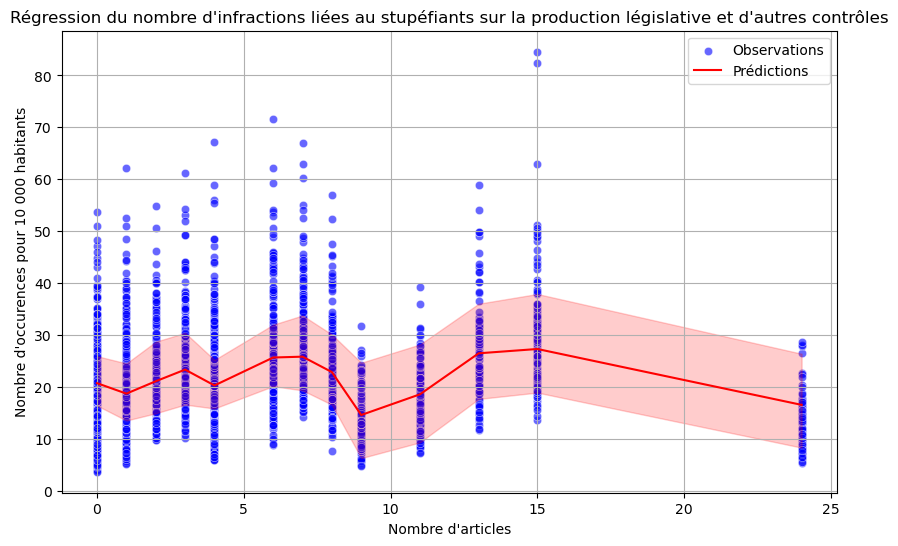

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.3904
 Estimator:                   PanelOLS   R-squared (Between):             -43.381
 No. Observations:                2592   R-squared (Within):               0.3904
 Date:                Sun, Dec 29 2024   R-squared (Overall):             -18.741
 Time:                        16:37:12   Log-likelihood                   -8267.9
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      399.06
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2492)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             399.06
     

In [53]:
regression(mise_en_forme_reg('stupéfiant', "Stupéfiants"), title="Régression du nombre d'infractions liées au stupéfiants sur la production législative et d'autres contrôles", entity_effects=True, lag = 2)

In [65]:
from IPython.display import clear_output

def regression_lags(df, title, entity_effects=False):
    """
    Effectue des régressions avec des lags de 1 à 5 sur les articles,
    et retourne les p-values des coefficients de 'Articles_lag x' et le R² de chaque régression.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        title (str): Ajuster le titre du graphique.
        entity_effects (bool): Inclure ou non les effets fixes des entités.

    Returns:
        list: Liste de tuples (p-value de 'Articles_lag x', R²) pour x allant de 1 à 5.
    """
    results_list = []

    for lag in range(1, 6):
        # Appel de la fonction existante pour chaque lag
        res = regression(df.copy(), title + f" (Lag {lag})", entity_effects, lag=lag)
        clear_output(wait=True)

        r_squared = float(res['results'].rsquared)  # Conversion en float
        
        # Extraction des coefficients sous forme de DataFrame
        summary_df = res['results'].params.to_frame(name='coef')
        summary_df['pvalue'] = res['results'].pvalues
        summary_df['stderr'] = res['results'].std_errors
        
        # Filtrer pour obtenir 'Articles_lag x'
        article_lag_row = summary_df.filter(like=f"Articles_lag{lag}", axis=0)
        
        if not article_lag_row.empty:
            p_value = float(article_lag_row['pvalue'].values[0])  # Conversion directe
            results_list.append((p_value, r_squared))

    return results_list


In [66]:
regression_lags(mise_en_forme_reg('stupéfiant', "Stupéfiants"), "Régression avec lags", entity_effects = True)

[(4.7448513504244616e-05, 0.39288196205159265),
 (0.010337604830944258, 0.39044724570641076),
 (0.03688942160647368, 0.38990380951319625),
 (1.362385981806824e-08, 0.3966939064195185),
 (0.0, 0.4065797367843005)]